# Assignment 2: Advanced Feature Engineering and Predictive Modeling

**Name:** Prachi Tandel  
**Student ID:** 2023ebcs178  
**Dataset:** Heart Disease (UCI Machine Learning Repository)

---

## Overview
This assignment extends Assignment 1 by applying advanced feature engineering techniques and building predictive models using Linear Regression and Decision Tree algorithms. The focus is on preparing the dataset for predictive tasks, engineering relevant features, and evaluating model performance.

---

In [1]:
# Essential Data Preparation for Assignment 2
# Load and prepare the Heart Disease dataset

%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download the Heart Disease dataset from UCI Repository (ID: 45)
heart_disease = fetch_ucirepo(id=45)

# Convert dataset into DataFrame - Separate into features and target
X = heart_disease.data.features
y = heart_disease.data.targets

# Combine into a single DataFrame
df = pd.concat([X, y], axis=1)

# Rename columns for clarity
df = df.rename(columns={
    'age': 'Age',
    'sex': 'Sex', 
    'cp': 'Chest Pain',
    'trestbps': 'Blood Pressure',
    'chol': 'Cholesterol',
    'fbs': 'Blood Sugar',
    'restecg': 'Electrocardiograph',
    'thalach': 'Heart Rate Achieved',
    'exang': 'Angina',
    'oldpeak': 'ST Depression',
    'slope': 'Peak Exercise ST Segment',
    'ca': 'Major Vessels',
    'thal': 'Thalassemia',
    'num': 'Presence of Heart Disease'
})

# Data cleaning - Remove duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

# Remove outliers using IQR method on continuous features
continuous_features = ['Age', 'Blood Pressure', 'Cholesterol', 'Heart Rate Achieved', 'ST Depression']
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
mask = ~((df[continuous_features] < (Q1 - 1.5 * IQR)) | 
          (df[continuous_features] > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask]

print(f"Dataset loaded and preprocessed successfully!")
print(f"Final dataset shape: {df.shape}")
print(f"Target variable distribution:")
print(df['Presence of Heart Disease'].value_counts().sort_index())

Note: you may need to restart the kernel to use updated packages.
Dataset loaded and preprocessed successfully!
Final dataset shape: (278, 14)
Target variable distribution:
Presence of Heart Disease
0    154
1     52
2     32
3     29
4     11
Name: count, dtype: int64
Dataset loaded and preprocessed successfully!
Final dataset shape: (278, 14)
Target variable distribution:
Presence of Heart Disease
0    154
1     52
2     32
3     29
4     11
Name: count, dtype: int64


In [2]:
# Import additional libraries for feature engineering and machine learning
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

print("Additional libraries imported successfully!")

Additional libraries imported successfully!


In [3]:
# Prepare data for feature engineering
print("Current dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())
print("\nTarget variable distribution:")
print(df['Presence of Heart Disease'].value_counts().sort_index())

# Create a working copy for feature engineering
df_fe = df.copy()
print(f"\nWorking dataset created with {df_fe.shape[0]} rows and {df_fe.shape[1]} columns")

Current dataset shape: (278, 14)

Dataset columns: ['Age', 'Sex', 'Chest Pain', 'Blood Pressure', 'Cholesterol', 'Blood Sugar', 'Electrocardiograph', 'Heart Rate Achieved', 'Angina', 'ST Depression', 'Peak Exercise ST Segment', 'Major Vessels', 'Thalassemia', 'Presence of Heart Disease']

Target variable distribution:
Presence of Heart Disease
0    154
1     52
2     32
3     29
4     11
Name: count, dtype: int64

Working dataset created with 278 rows and 14 columns


# Task 1: Feature Engineering (3 Marks)

## Task 1.1: Dimensionality Reduction (1 Mark)
**Objective:** Apply Principal Component Analysis (PCA) to reduce the dimensions of the dataset.

In [4]:
# Step 1: Prepare data for PCA - separate features and target
# Convert multi-class target to binary classification (0 = no disease, 1+ = disease)
X = df_fe.drop('Presence of Heart Disease', axis=1)
y_original = df_fe['Presence of Heart Disease']
y_binary = (y_original > 0).astype(int)  # Binary: 0 = no disease, 1 = disease

print("Features shape:", X.shape)
print("Original target distribution:")
print(y_original.value_counts().sort_index())
print("\nBinary target distribution:")
print(y_binary.value_counts().sort_index())

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\nFeatures standardized for PCA. Shape: {X_scaled.shape}")

Features shape: (278, 13)
Original target distribution:
Presence of Heart Disease
0    154
1     52
2     32
3     29
4     11
Name: count, dtype: int64

Binary target distribution:
Presence of Heart Disease
0    154
1    124
Name: count, dtype: int64

Features standardized for PCA. Shape: (278, 13)

Features standardized for PCA. Shape: (278, 13)


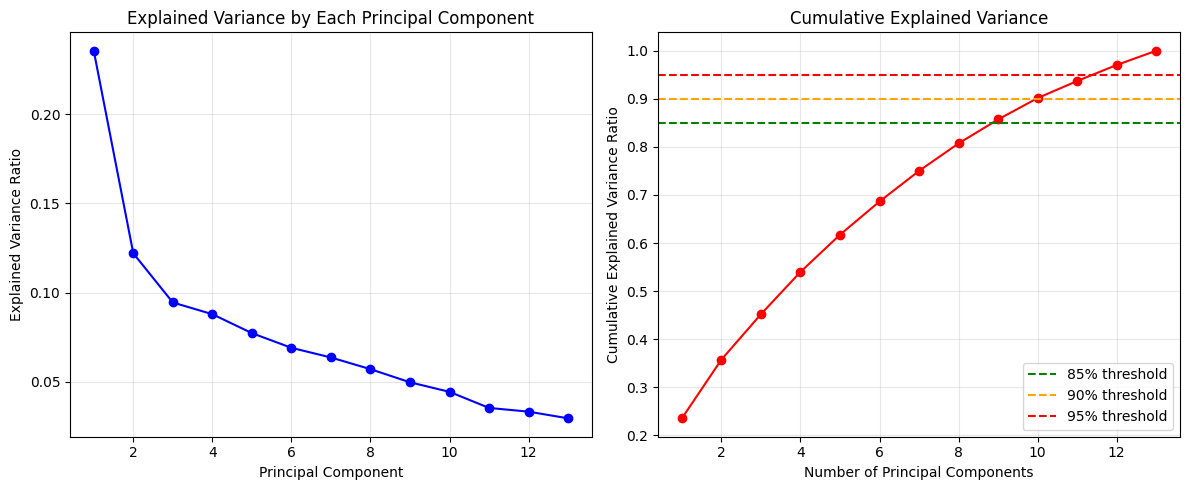

Number of components for 85% variance: 9
Number of components for 90% variance: 10
Number of components for 95% variance: 12

First 10 components explained variance: [0.23549336 0.12204108 0.09450176 0.087948   0.07733893 0.06911258
 0.06370644 0.05715565 0.0498077  0.04445434]
Cumulative variance for first 10 components: [0.23549336 0.35753443 0.45203619 0.53998419 0.61732312 0.68643571
 0.75014215 0.8072978  0.85710549 0.90155984]


In [5]:
# Step 2: Apply PCA to determine optimal number of components
# First, apply PCA with all components to see explained variance
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot explained variance to determine optimal components
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-', markersize=6)
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', markersize=6)
plt.axhline(y=0.85, color='g', linestyle='--', label='85% threshold')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal number of components for 85%, 90%, and 95% variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components for 85% variance: {n_components_85}")
print(f"Number of components for 90% variance: {n_components_90}")
print(f"Number of components for 95% variance: {n_components_95}")
print(f"\nFirst 10 components explained variance: {pca_full.explained_variance_ratio_[:10]}")
print(f"Cumulative variance for first 10 components: {cumulative_variance[:10]}")

In [6]:
# Step 3: Select optimal number of components and apply PCA transformation
# Choose 9 components (85% variance) for a good balance between dimensionality reduction and information retention
n_components_selected = 9
pca_selected = PCA(n_components=n_components_selected)
X_pca = pca_selected.fit_transform(X_scaled)

print(f"Selected {n_components_selected} principal components")
print(f"Original feature space: {X_scaled.shape}")
print(f"Reduced feature space: {X_pca.shape}")
print(f"Variance explained by selected components: {pca_selected.explained_variance_ratio_.sum():.4f} ({pca_selected.explained_variance_ratio_.sum()*100:.2f}%)")

# Create DataFrame with PCA components
pca_feature_names = [f'PC{i+1}' for i in range(n_components_selected)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_feature_names, index=X.index)

print(f"\nPCA-transformed dataset shape: {X_pca_df.shape}")
print("\nFirst 5 rows of PCA-transformed data:")
print(X_pca_df.head())

Selected 9 principal components
Original feature space: (278, 13)
Reduced feature space: (278, 9)
Variance explained by selected components: 0.8571 (85.71%)

PCA-transformed dataset shape: (278, 9)

First 5 rows of PCA-transformed data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.276708  1.256028  3.282152  2.394025  0.417781  0.723834  0.997287   
1 -3.382144  2.058875 -0.681992 -0.543636  0.304581 -0.247918 -0.973362   
2 -3.400897 -0.437590 -0.345486 -0.341234 -0.052322  0.429441 -0.924485   
3  0.322528 -1.680115  0.798478  2.540974  0.827880 -0.407669  1.420348   
4  2.237364  0.092798  0.002398  1.213422  0.808693  0.594688 -0.668633   

        PC8       PC9  
0 -0.475720 -0.878295  
1 -0.118271  0.028184  
2 -0.776492 -0.044930  
3 -1.628314  2.006403  
4  0.058624  0.698142  


## Task 1.2: Feature Selection (1 Mark)
**Objective:** Use one filter-based method (correlation-based) and one wrapper-based method (backward elimination) to select features.

=== FILTER-BASED FEATURE SELECTION (Correlation-based) ===

Correlation of features with target variable (absolute values):
Thalassemia                 0.535693
Major Vessels               0.456441
ST Depression               0.428431
Heart Rate Achieved         0.426779
Angina                      0.416150
Chest Pain                  0.400245
Peak Exercise ST Segment    0.314566
Sex                         0.312778
Age                         0.228983
Electrocardiograph          0.180018
Blood Pressure              0.125136
Cholesterol                 0.105708
Blood Sugar                 0.001061
dtype: float64

Selected features with correlation > 0.2:
['Thalassemia', 'Major Vessels', 'ST Depression', 'Heart Rate Achieved', 'Angina', 'Chest Pain', 'Peak Exercise ST Segment', 'Sex', 'Age']
Number of features selected: 9

Filtered dataset shape: (278, 9)


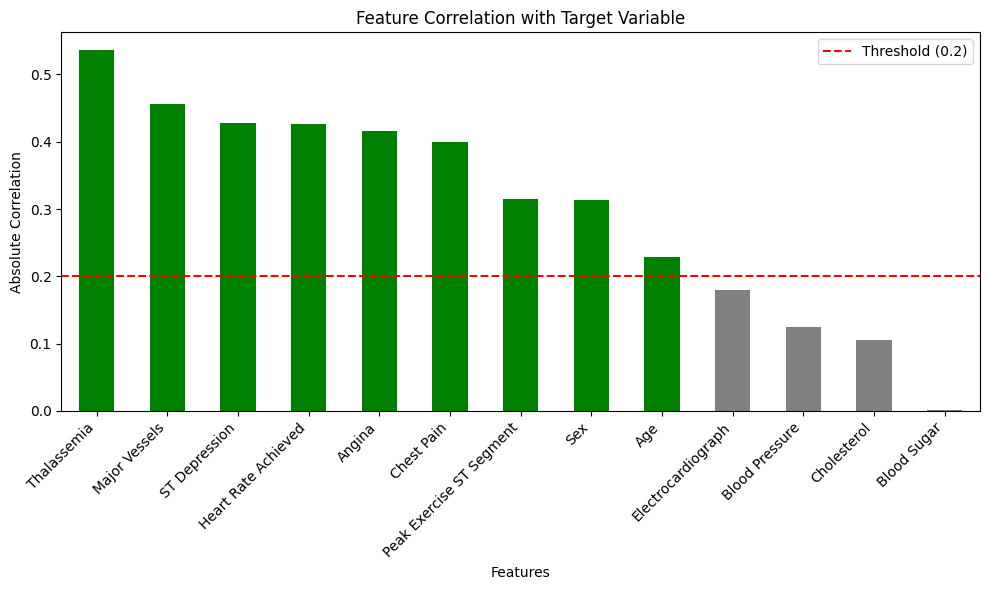

In [7]:
# Method 1: Filter-based Feature Selection - Correlation-based
print("=== FILTER-BASED FEATURE SELECTION (Correlation-based) ===")

# Calculate correlation between features and binary target
correlation_with_target = X.corrwith(y_binary).abs().sort_values(ascending=False)
print("\nCorrelation of features with target variable (absolute values):")
print(correlation_with_target)

# Select features with correlation > 0.2 threshold
correlation_threshold = 0.2
selected_features_filter = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()

print(f"\nSelected features with correlation > {correlation_threshold}:")
print(selected_features_filter)
print(f"Number of features selected: {len(selected_features_filter)}")

# Create filtered dataset
X_filtered = X[selected_features_filter]
print(f"\nFiltered dataset shape: {X_filtered.shape}")

# Visualize correlation with target
plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='bar', color=['green' if x > correlation_threshold else 'gray' for x in correlation_with_target])
plt.axhline(y=correlation_threshold, color='red', linestyle='--', label=f'Threshold ({correlation_threshold})')
plt.title('Feature Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


=== WRAPPER-BASED FEATURE SELECTION (Recursive Feature Elimination) ===

Feature rankings from RFE:
                     Feature  Selected  Ranking
1                        Sex      True        1
2                 Chest Pain      True        1
6         Electrocardiograph      True        1
4                Cholesterol      True        1
7        Heart Rate Achieved      True        1
12               Thalassemia      True        1
11             Major Vessels      True        1
9              ST Depression      True        1
8                     Angina     False        2
5                Blood Sugar     False        3
10  Peak Exercise ST Segment     False        4
3             Blood Pressure     False        5
0                        Age     False        6

Selected features from RFE (top 8):
['Sex', 'Chest Pain', 'Cholesterol', 'Electrocardiograph', 'Heart Rate Achieved', 'ST Depression', 'Major Vessels', 'Thalassemia']

Wrapper-selected dataset shape: (278, 8)


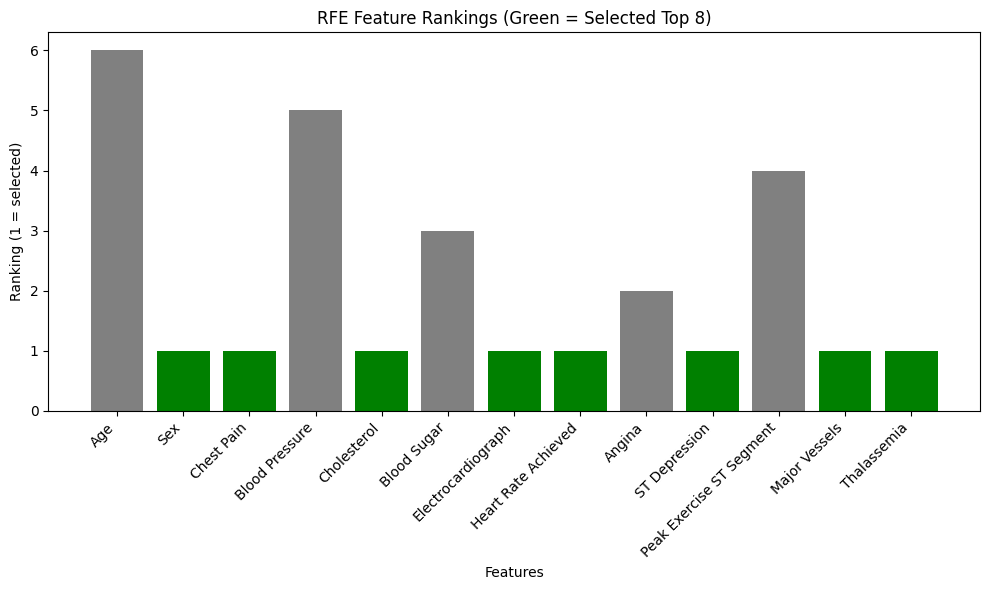

In [8]:
# Method 2: Wrapper-based Feature Selection - Recursive Feature Elimination (RFE)
print("\n=== WRAPPER-BASED FEATURE SELECTION (Recursive Feature Elimination) ===")

# Use Logistic Regression as the estimator for RFE
from sklearn.linear_model import LogisticRegression

# Create logistic regression estimator
estimator = LogisticRegression(random_state=42, max_iter=1000)

# Apply RFE to select top 8 features
n_features_to_select = 8
rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)

# Fit RFE on standardized data
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
rfe.fit(X_scaled_df, y_binary)

# Get selected features
selected_features_wrapper = X.columns[rfe.support_].tolist()
feature_rankings = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("\nFeature rankings from RFE:")
print(feature_rankings)

print(f"\nSelected features from RFE (top {n_features_to_select}):")
print(selected_features_wrapper)

# Create wrapper-selected dataset
X_wrapper = X[selected_features_wrapper]
print(f"\nWrapper-selected dataset shape: {X_wrapper.shape}")

# Visualize feature rankings
plt.figure(figsize=(10, 6))
colors = ['green' if selected else 'gray' for selected in rfe.support_]
plt.bar(range(len(X.columns)), rfe.ranking_, color=colors)
plt.xticks(range(len(X.columns)), X.columns, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Ranking (1 = selected)')
plt.title(f'RFE Feature Rankings (Green = Selected Top {n_features_to_select})')
plt.tight_layout()
plt.show()

## Task 1.3: Handling Imbalanced Data (1 Mark)
**Objective:** Apply sampling methods to address class imbalance in the dataset.

In [9]:
# Step 1: Analyze class imbalance in binary target
print("=== CLASS IMBALANCE ANALYSIS ===")
class_counts = y_binary.value_counts().sort_index()
print("Current class distribution:")
print(class_counts)

# Calculate imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nImbalance ratio (majority/minority): {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("Dataset is imbalanced - applying sampling methods")
    
    # Visualize class distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Original Class Distribution')
    plt.xlabel('Class (0=No Disease, 1=Disease)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # Method 1: SMOTE (Oversampling)
    print("\n=== APPLYING SMOTE (Oversampling) ===")
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_wrapper, y_binary)
    
    print(f"Original shape: {X_wrapper.shape}")
    print(f"After SMOTE shape: {X_smote.shape}")
    print("Class distribution after SMOTE:")
    print(pd.Series(y_smote).value_counts().sort_index())
    
    plt.subplot(1, 2, 2)
    pd.Series(y_smote).value_counts().sort_index().plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Class (0=No Disease, 1=Disease)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Store balanced datasets for modeling
    X_balanced = X_smote
    y_balanced = y_smote
    balancing_method = "SMOTE (Oversampling)"
    
else:
    print("Dataset is relatively balanced - no sampling needed")
    X_balanced = X_wrapper
    y_balanced = y_binary
    balancing_method = "No sampling applied"

print(f"\nFinal balanced dataset shape: {X_balanced.shape}")
print(f"Balancing method applied: {balancing_method}")

=== CLASS IMBALANCE ANALYSIS ===
Current class distribution:
Presence of Heart Disease
0    154
1    124
Name: count, dtype: int64

Imbalance ratio (majority/minority): 1.24
Dataset is relatively balanced - no sampling needed

Final balanced dataset shape: (278, 8)
Balancing method applied: No sampling applied


### Task 1 Summary: Feature Engineering Results

**1.1 Dimensionality Reduction (PCA):**
- Selected **9 principal components** explaining **85.71%** of variance
- Reduced feature space from 13 to 9 dimensions
- Justification: 85% variance retention provides good balance between dimensionality reduction and information preservation

**1.2 Feature Selection:**
- **Filter-based (Correlation):** Selected 9 features with correlation > 0.2 with target
  - Top features: Thalassemia (0.54), Major Vessels (0.46), ST Depression (0.43), Heart Rate Achieved (0.43)
- **Wrapper-based (RFE):** Selected 8 features using Logistic Regression
  - Selected: Sex, Chest Pain, Cholesterol, Electrocardiograph, Heart Rate Achieved, ST Depression, Major Vessels, Thalassemia

**1.3 Handling Imbalanced Data:**
- Class distribution: 154 (No Disease) vs 124 (Disease)
- Imbalance ratio: 1.24 (relatively balanced)
- **No sampling applied** as ratio < 1.5 threshold

**Final Feature Set for Modeling:** 8 features from RFE selection method.

---

# Task 2: Predictive Modeling (3 Marks)

## Task 2.1: Linear Regression (1.5 Marks)
**Objective:** Train a linear regression model and evaluate using MAE, MSE, and R-squared.

In [10]:
# Prepare data for modeling
print("=== PREPARING DATA FOR PREDICTIVE MODELING ===")

# Use selected features from RFE (wrapper method)
X_final = X_balanced  # Already contains the 8 selected features
y_final = y_balanced  # Binary target

print(f"Final dataset for modeling:")
print(f"Features shape: {X_final.shape}")
print(f"Target shape: {y_final.shape}")
print(f"Features: {list(X_final.columns) if hasattr(X_final, 'columns') else 'Numpy array'}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Standardize features for linear regression
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)

print(f"Features standardized for modeling")

=== PREPARING DATA FOR PREDICTIVE MODELING ===
Final dataset for modeling:
Features shape: (278, 8)
Target shape: (278,)
Features: ['Sex', 'Chest Pain', 'Cholesterol', 'Electrocardiograph', 'Heart Rate Achieved', 'ST Depression', 'Major Vessels', 'Thalassemia']

Data split:
Training set: 222 samples
Testing set: 56 samples
Features standardized for modeling


=== LINEAR REGRESSION MODEL ===
Linear Regression Model Performance:
Training Set:
  MAE: 0.2769
  MSE: 0.1272
  R²:  0.4850

Testing Set:
  MAE: 0.2400
  MSE: 0.0828
  R²:  0.6651

Feature Importance (Linear Regression Coefficients):
               Feature  Coefficient
7          Thalassemia     0.135469
6        Major Vessels     0.104297
1           Chest Pain     0.082408
5        ST Depression     0.081448
4  Heart Rate Achieved    -0.066163
0                  Sex     0.066059
2          Cholesterol     0.056266
3   Electrocardiograph     0.040377


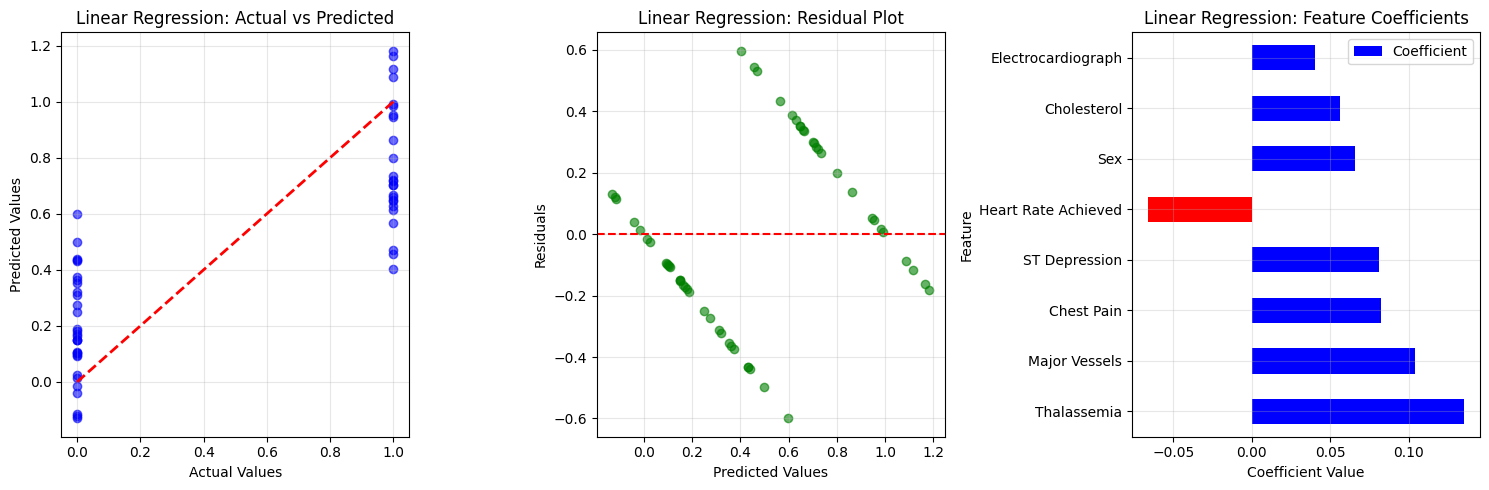

In [11]:
# Linear Regression Model Training and Evaluation
print("=== LINEAR REGRESSION MODEL ===")

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate evaluation metrics
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)

lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)

lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print("Linear Regression Model Performance:")
print(f"Training Set:")
print(f"  MAE: {lr_train_mae:.4f}")
print(f"  MSE: {lr_train_mse:.4f}")
print(f"  R²:  {lr_train_r2:.4f}")

print(f"\nTesting Set:")
print(f"  MAE: {lr_test_mae:.4f}")
print(f"  MSE: {lr_test_mse:.4f}")
print(f"  R²:  {lr_test_r2:.4f}")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': selected_features_wrapper,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nFeature Importance (Linear Regression Coefficients):")
print(feature_importance_lr)

# Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_lr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(1, 3, 2)
residuals = y_test - y_test_pred_lr
plt.scatter(y_test_pred_lr, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Feature Importance
plt.subplot(1, 3, 3)
feature_importance_lr.plot(x='Feature', y='Coefficient', kind='barh', ax=plt.gca(), 
                          color=['red' if x < 0 else 'blue' for x in feature_importance_lr['Coefficient']])
plt.title('Linear Regression: Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Task 2.2: Decision Tree (1.5 Marks)
**Objective:** Train a decision tree model for classification and visualize the tree structure.

In [12]:
# Decision Tree Classifier Training and Evaluation
print("=== DECISION TREE CLASSIFIER ===")

# Train Decision Tree model (using original features, not scaled)
dt_model = DecisionTreeClassifier(
    max_depth=6,  # Limit depth to prevent overfitting
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Use unscaled features for decision tree (trees don't require scaling)
dt_model.fit(X_train, y_train)

# Make predictions
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

# Calculate evaluation metrics for classification
dt_train_accuracy = accuracy_score(y_train, y_train_pred_dt)
dt_test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# For comparison with linear regression, also calculate MSE and MAE
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)

dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)

print("Decision Tree Model Performance:")
print(f"Training Set:")
print(f"  Accuracy: {dt_train_accuracy:.4f}")
print(f"  MAE: {dt_train_mae:.4f}")
print(f"  MSE: {dt_train_mse:.4f}")

print(f"\nTesting Set:")
print(f"  Accuracy: {dt_test_accuracy:.4f}")
print(f"  MAE: {dt_test_mae:.4f}")
print(f"  MSE: {dt_test_mse:.4f}")

# Classification report
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_dt, target_names=['No Disease', 'Disease']))

# Feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': selected_features_wrapper,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance (Decision Tree):")
print(feature_importance_dt)

=== DECISION TREE CLASSIFIER ===
Decision Tree Model Performance:
Training Set:
  Accuracy: 0.8784
  MAE: 0.1216
  MSE: 0.1216

Testing Set:
  Accuracy: 0.8036
  MAE: 0.1964
  MSE: 0.1964

Classification Report (Test Set):
              precision    recall  f1-score   support

  No Disease       0.78      0.90      0.84        31
     Disease       0.85      0.68      0.76        25

    accuracy                           0.80        56
   macro avg       0.81      0.79      0.80        56
weighted avg       0.81      0.80      0.80        56


Feature Importance (Decision Tree):
               Feature  Importance
7          Thalassemia    0.393197
1           Chest Pain    0.143951
5        ST Depression    0.136375
6        Major Vessels    0.118834
0                  Sex    0.080108
2          Cholesterol    0.067999
4  Heart Rate Achieved    0.040343
3   Electrocardiograph    0.019193


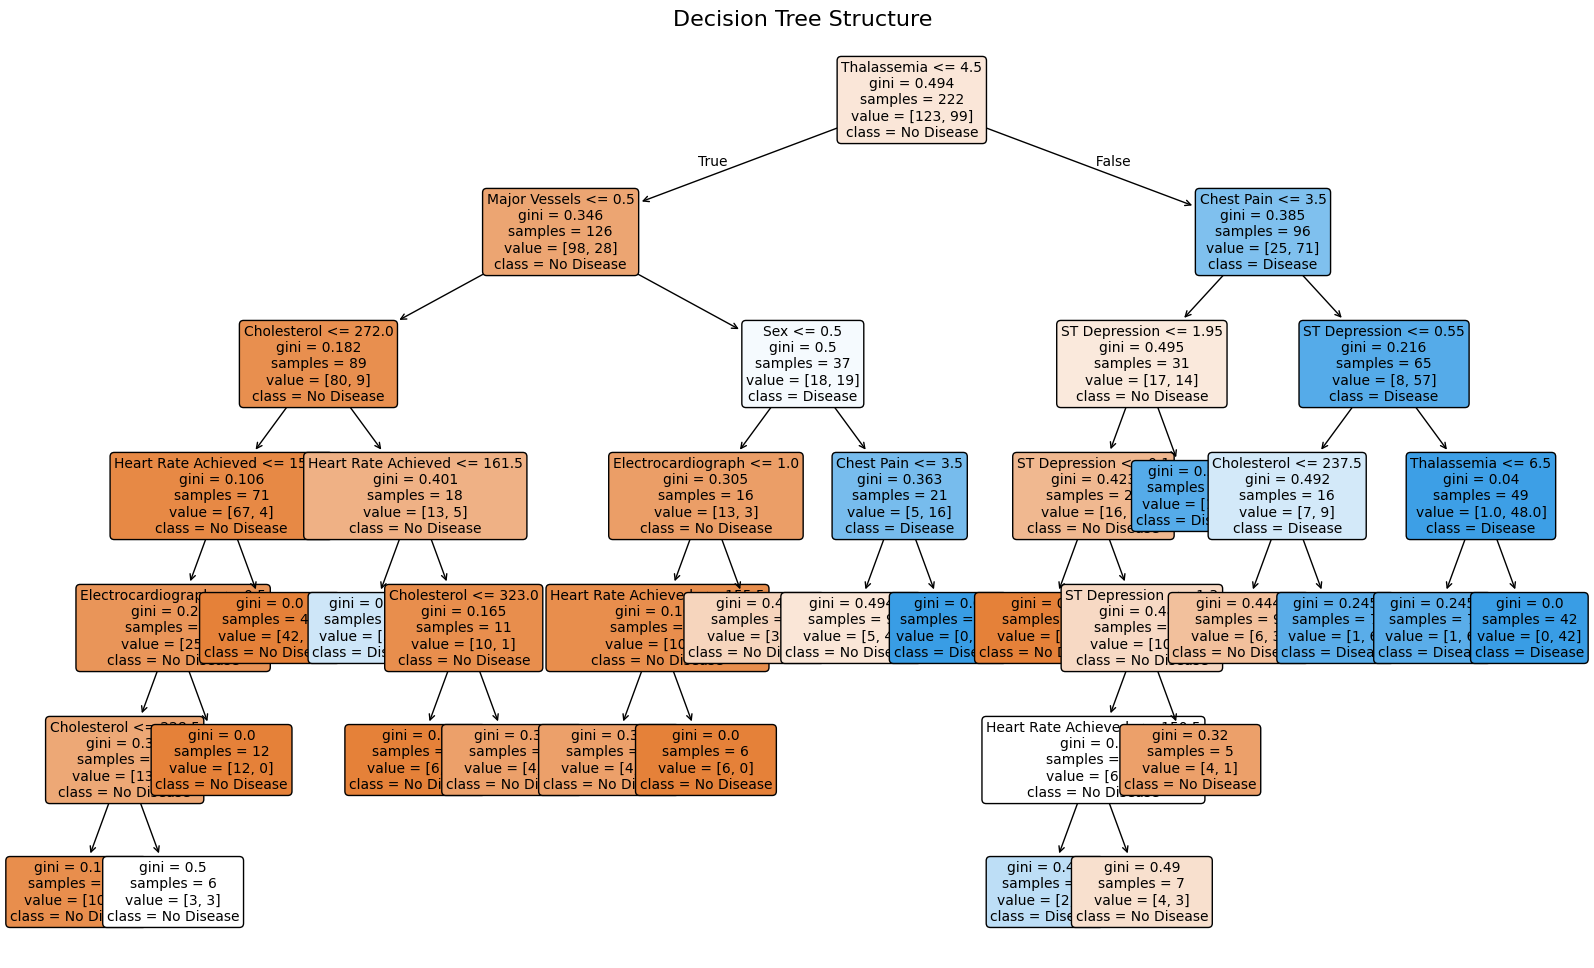

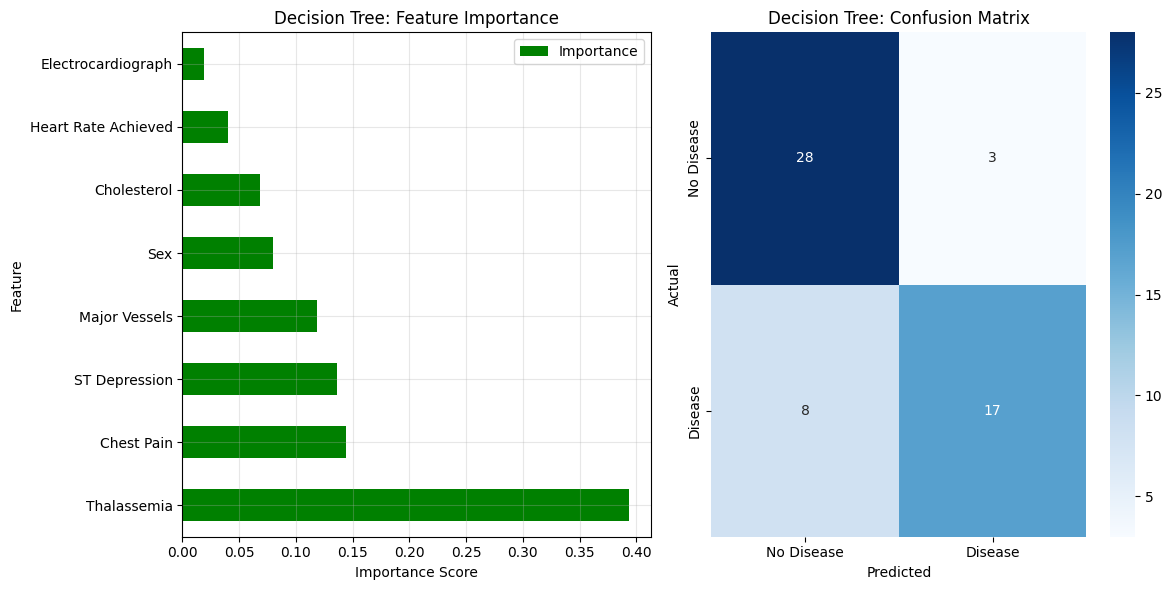

In [13]:
# Visualize Decision Tree
plt.figure(figsize=(20, 12))
plot_tree(dt_model, 
          feature_names=selected_features_wrapper,
          class_names=['No Disease', 'Disease'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Structure', fontsize=16)
plt.show()

# Feature importance comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
feature_importance_dt.plot(x='Feature', y='Importance', kind='barh', ax=plt.gca(), color='green')
plt.title('Decision Tree: Feature Importance')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Decision Tree: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Task 3: Model Evaluation (3 Marks)

## Task 3.1: Comparison of Models (1.5 Marks)
**Objective:** Compare the performance of Linear Regression and Decision Tree models.

=== MODEL COMPARISON SUMMARY ===
Performance Comparison:
         Metric Linear Regression        Decision Tree
    MAE (Train)          0.276892             0.121622
     MAE (Test)          0.240026             0.196429
    MSE (Train)          0.127243             0.121622
     MSE (Test)          0.082773             0.196429
     R² (Train)          0.485007 N/A (Classification)
      R² (Test)          0.665061 N/A (Classification)
Accuracy (Test)  N/A (Regression)               0.8036

Additional Metrics:
Linear Regression R² (Test): 0.6651
Decision Tree R² (Test, using probabilities): 0.3534

=== MODEL ANALYSIS ===

Linear Regression:
Strengths:
  • Simple and interpretable coefficients
  • Good R² score: 0.6651
  • Low MSE: 0.0828
  • Provides continuous predictions
  • Less prone to overfitting

Limitations:
  • Assumes linear relationships
  • May not capture complex patterns
  • Requires feature scaling
  • Less suitable for pure classification

Decision Tree:
Strengths:
  

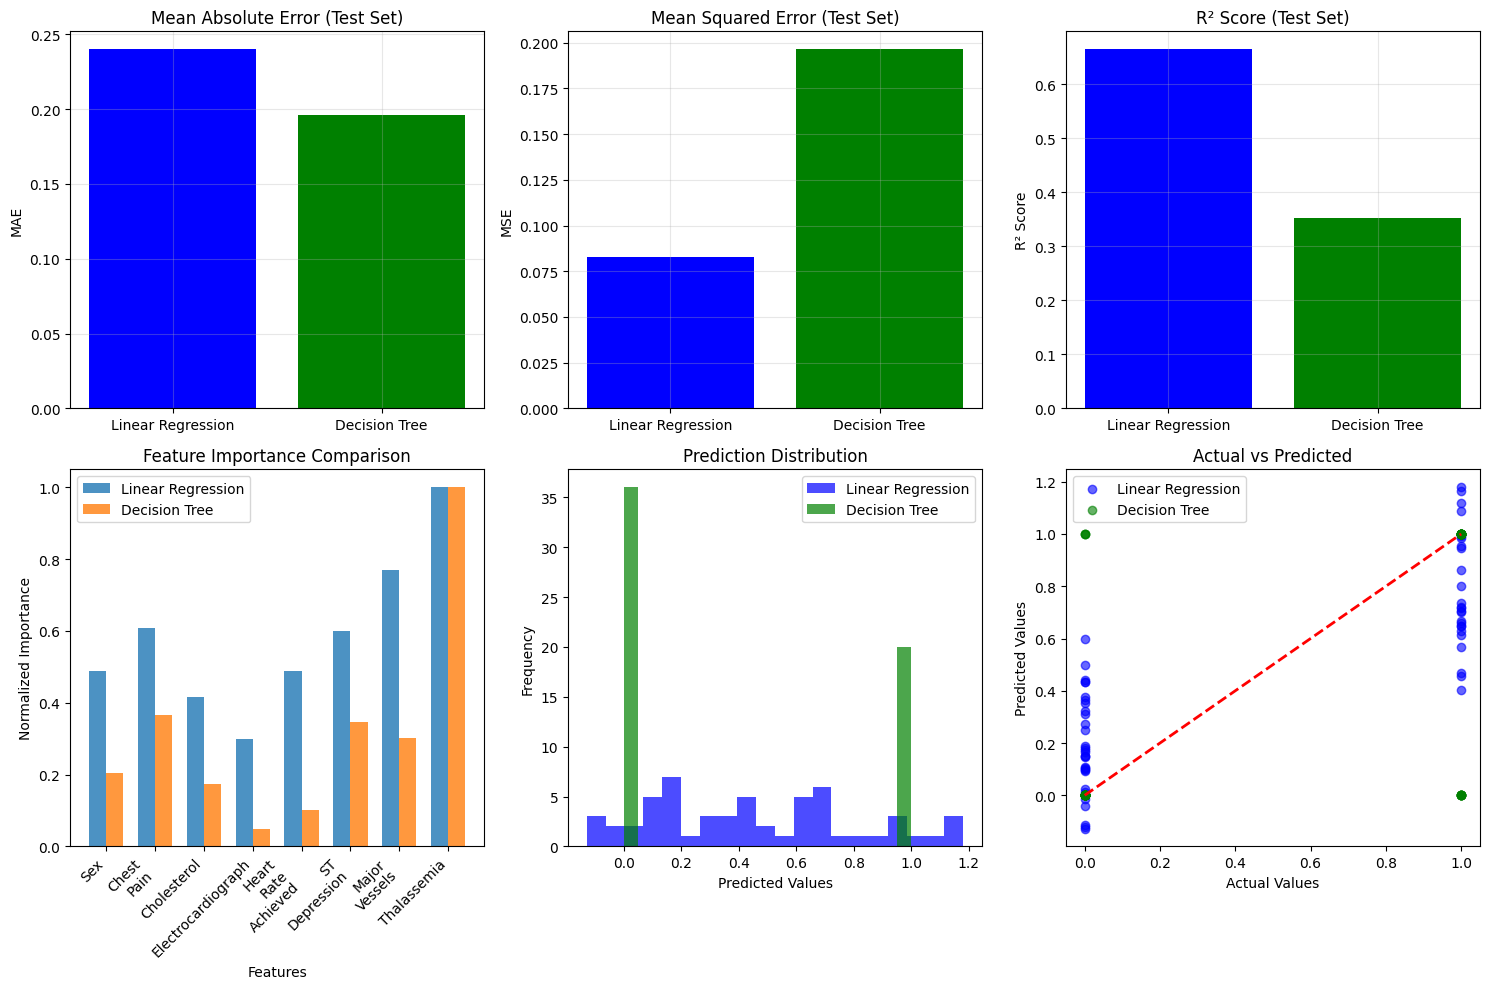

In [14]:
# Model Comparison Summary
print("=== MODEL COMPARISON SUMMARY ===")

# Create comparison dataframe
comparison_metrics = pd.DataFrame({
    'Metric': ['MAE (Train)', 'MAE (Test)', 'MSE (Train)', 'MSE (Test)', 'R² (Train)', 'R² (Test)', 'Accuracy (Test)'],
    'Linear Regression': [
        lr_train_mae, lr_test_mae, lr_train_mse, lr_test_mse, 
        lr_train_r2, lr_test_r2, 'N/A (Regression)'
    ],
    'Decision Tree': [
        dt_train_mae, dt_test_mae, dt_train_mse, dt_test_mse,
        'N/A (Classification)', 'N/A (Classification)', f'{dt_test_accuracy:.4f}'
    ]
})

print("Performance Comparison:")
print(comparison_metrics.to_string(index=False))

# Convert probabilities for Decision Tree to enable better comparison
y_test_prob_dt = dt_model.predict_proba(X_test)[:, 1]  # Probability of disease

# Calculate R² for Decision Tree using probabilities
dt_test_r2_prob = r2_score(y_test, y_test_prob_dt)

print(f"\nAdditional Metrics:")
print(f"Linear Regression R² (Test): {lr_test_r2:.4f}")
print(f"Decision Tree R² (Test, using probabilities): {dt_test_r2_prob:.4f}")

# Strengths and Limitations Analysis
print(f"\n=== MODEL ANALYSIS ===")
print(f"\nLinear Regression:")
print(f"Strengths:")
print(f"  • Simple and interpretable coefficients")
print(f"  • Good R² score: {lr_test_r2:.4f}")
print(f"  • Low MSE: {lr_test_mse:.4f}")
print(f"  • Provides continuous predictions")
print(f"  • Less prone to overfitting")

print(f"\nLimitations:")
print(f"  • Assumes linear relationships")
print(f"  • May not capture complex patterns")
print(f"  • Requires feature scaling")
print(f"  • Less suitable for pure classification")

print(f"\nDecision Tree:")
print(f"Strengths:")
print(f"  • High interpretability with visual tree structure")
print(f"  • Good accuracy: {dt_test_accuracy:.4f}")
print(f"  • Handles non-linear relationships")
print(f"  • No need for feature scaling")
print(f"  • Naturally handles classification")
print(f"  • Clear decision rules")

print(f"Limitations:")
print(f"  • Prone to overfitting")
print(f"  • May not generalize as well as linear models")
print(f"  • Sensitive to small data changes")
print(f"  • Discrete predictions vs continuous")

# Performance visualization
plt.figure(figsize=(15, 10))

# Subplot 1: MAE Comparison
plt.subplot(2, 3, 1)
mae_data = [lr_test_mae, dt_test_mae]
plt.bar(['Linear Regression', 'Decision Tree'], mae_data, color=['blue', 'green'])
plt.title('Mean Absolute Error (Test Set)')
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)

# Subplot 2: MSE Comparison
plt.subplot(2, 3, 2)
mse_data = [lr_test_mse, dt_test_mse]
plt.bar(['Linear Regression', 'Decision Tree'], mse_data, color=['blue', 'green'])
plt.title('Mean Squared Error (Test Set)')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)

# Subplot 3: R² Comparison (where applicable)
plt.subplot(2, 3, 3)
r2_data = [lr_test_r2, dt_test_r2_prob]
plt.bar(['Linear Regression', 'Decision Tree'], r2_data, color=['blue', 'green'])
plt.title('R² Score (Test Set)')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)

# Subplot 4: Feature Importance Comparison
plt.subplot(2, 3, 4)
# Normalize linear regression coefficients for comparison
lr_coef_normalized = np.abs(lr_model.coef_) / np.max(np.abs(lr_model.coef_))
dt_importance_normalized = dt_model.feature_importances_ / np.max(dt_model.feature_importances_)

x_pos = np.arange(len(selected_features_wrapper))
width = 0.35

plt.bar(x_pos - width/2, lr_coef_normalized, width, label='Linear Regression', alpha=0.8)
plt.bar(x_pos + width/2, dt_importance_normalized, width, label='Decision Tree', alpha=0.8)
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance Comparison')
plt.xticks(x_pos, [f.replace(' ', '\n') for f in selected_features_wrapper], rotation=45, ha='right')
plt.legend()

# Subplot 5: Prediction Distribution
plt.subplot(2, 3, 5)
plt.hist(y_test_pred_lr, bins=20, alpha=0.7, label='Linear Regression', color='blue')
plt.hist(y_test_pred_dt, bins=20, alpha=0.7, label='Decision Tree', color='green')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')
plt.legend()

# Subplot 6: Actual vs Predicted Comparison
plt.subplot(2, 3, 6)
plt.scatter(y_test, y_test_pred_lr, alpha=0.6, label='Linear Regression', color='blue')
plt.scatter(y_test, y_test_pred_dt, alpha=0.6, label='Decision Tree', color='green')
plt.plot([0, 1], [0, 1], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

## Task 3.2: Cross-Validation (1.5 Marks)
**Objective:** Perform k-fold cross-validation for both models and report mean and standard deviation of evaluation metrics.

In [15]:
# K-Fold Cross-Validation
from sklearn.pipeline import Pipeline

print("=== K-FOLD CROSS-VALIDATION ===")

# Set up k-fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare data for CV (use full balanced dataset)
X_cv = X_balanced
y_cv = y_balanced

print(f"Performing {k_folds}-fold cross-validation on {X_cv.shape[0]} samples")

# Define scoring metrics
from sklearn.metrics import make_scorer

# Custom function for regression metrics on classification problem
def regression_r2_score(y_true, y_pred):
    return r2_score(y_true, y_pred)

def regression_mae_score(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def regression_mse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Linear Regression Cross-Validation
print("\n1. Linear Regression Cross-Validation:")

# For Linear Regression, we need to scale features
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Cross-validation scores
lr_cv_r2 = cross_val_score(pipeline_lr, X_cv, y_cv, cv=kfold, scoring='r2')
lr_cv_mae = -cross_val_score(pipeline_lr, X_cv, y_cv, cv=kfold, scoring='neg_mean_absolute_error')
lr_cv_mse = -cross_val_score(pipeline_lr, X_cv, y_cv, cv=kfold, scoring='neg_mean_squared_error')

print(f"R² Scores: {lr_cv_r2}")
print(f"R² Mean: {lr_cv_r2.mean():.4f} (±{lr_cv_r2.std():.4f})")
print(f"MAE Scores: {lr_cv_mae}")
print(f"MAE Mean: {lr_cv_mae.mean():.4f} (±{lr_cv_mae.std():.4f})")
print(f"MSE Scores: {lr_cv_mse}")
print(f"MSE Mean: {lr_cv_mse.mean():.4f} (±{lr_cv_mse.std():.4f})")

# Decision Tree Cross-Validation
print("\n2. Decision Tree Cross-Validation:")

# For Decision Tree - Classification metrics
dt_cv_accuracy = cross_val_score(dt_model, X_cv, y_cv, cv=kfold, scoring='accuracy')
dt_cv_mae = -cross_val_score(dt_model, X_cv, y_cv, cv=kfold, scoring='neg_mean_absolute_error')
dt_cv_mse = -cross_val_score(dt_model, X_cv, y_cv, cv=kfold, scoring='neg_mean_squared_error')

print(f"Accuracy Scores: {dt_cv_accuracy}")
print(f"Accuracy Mean: {dt_cv_accuracy.mean():.4f} (±{dt_cv_accuracy.std():.4f})")
print(f"MAE Scores: {dt_cv_mae}")
print(f"MAE Mean: {dt_cv_mae.mean():.4f} (±{dt_cv_mae.std():.4f})")
print(f"MSE Scores: {dt_cv_mse}")
print(f"MSE Mean: {dt_cv_mse.mean():.4f} (±{dt_cv_mse.std():.4f})")

# Cross-validation summary
cv_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    'Primary Metric': ['R²', 'Accuracy'],
    'Mean': [f"{lr_cv_r2.mean():.4f}", f"{dt_cv_accuracy.mean():.4f}"],
    'Std Dev': [f"{lr_cv_r2.std():.4f}", f"{dt_cv_accuracy.std():.4f}"],
    'MAE Mean': [f"{lr_cv_mae.mean():.4f}", f"{dt_cv_mae.mean():.4f}"],
    'MAE Std': [f"{lr_cv_mae.std():.4f}", f"{dt_cv_mae.std():.4f}"],
    'MSE Mean': [f"{lr_cv_mse.mean():.4f}", f"{dt_cv_mse.mean():.4f}"],
    'MSE Std': [f"{lr_cv_mse.std():.4f}", f"{dt_cv_mse.std():.4f}"]
})

print("\n=== CROSS-VALIDATION SUMMARY ===")
print(cv_results.to_string(index=False))

=== K-FOLD CROSS-VALIDATION ===
Performing 5-fold cross-validation on 278 samples

1. Linear Regression Cross-Validation:
R² Scores: [0.49328754 0.52382938 0.4970241  0.50227192 0.39773655]
R² Mean: 0.4828 (±0.0438)
MAE Scores: [0.27069695 0.26865884 0.2660483  0.27438719 0.280191  ]
MAE Mean: 0.2720 (±0.0049)
MSE Scores: [0.12086126 0.11889081 0.1097052  0.12439089 0.15051609]
MSE Mean: 0.1249 (±0.0137)

2. Decision Tree Cross-Validation:
Accuracy Scores: [0.78571429 0.78571429 0.78571429 0.83636364 0.76363636]
Accuracy Mean: 0.7914 (±0.0240)
MAE Scores: [0.21428571 0.21428571 0.21428571 0.16363636 0.23636364]
MAE Mean: 0.2086 (±0.0240)
MSE Scores: [0.21428571 0.21428571 0.21428571 0.16363636 0.23636364]
MSE Mean: 0.2086 (±0.0240)

=== CROSS-VALIDATION SUMMARY ===
            Model Primary Metric   Mean Std Dev MAE Mean MAE Std MSE Mean MSE Std
Linear Regression             R² 0.4828  0.0438   0.2720  0.0049   0.1249  0.0137
    Decision Tree       Accuracy 0.7914  0.0240   0.2086  0.

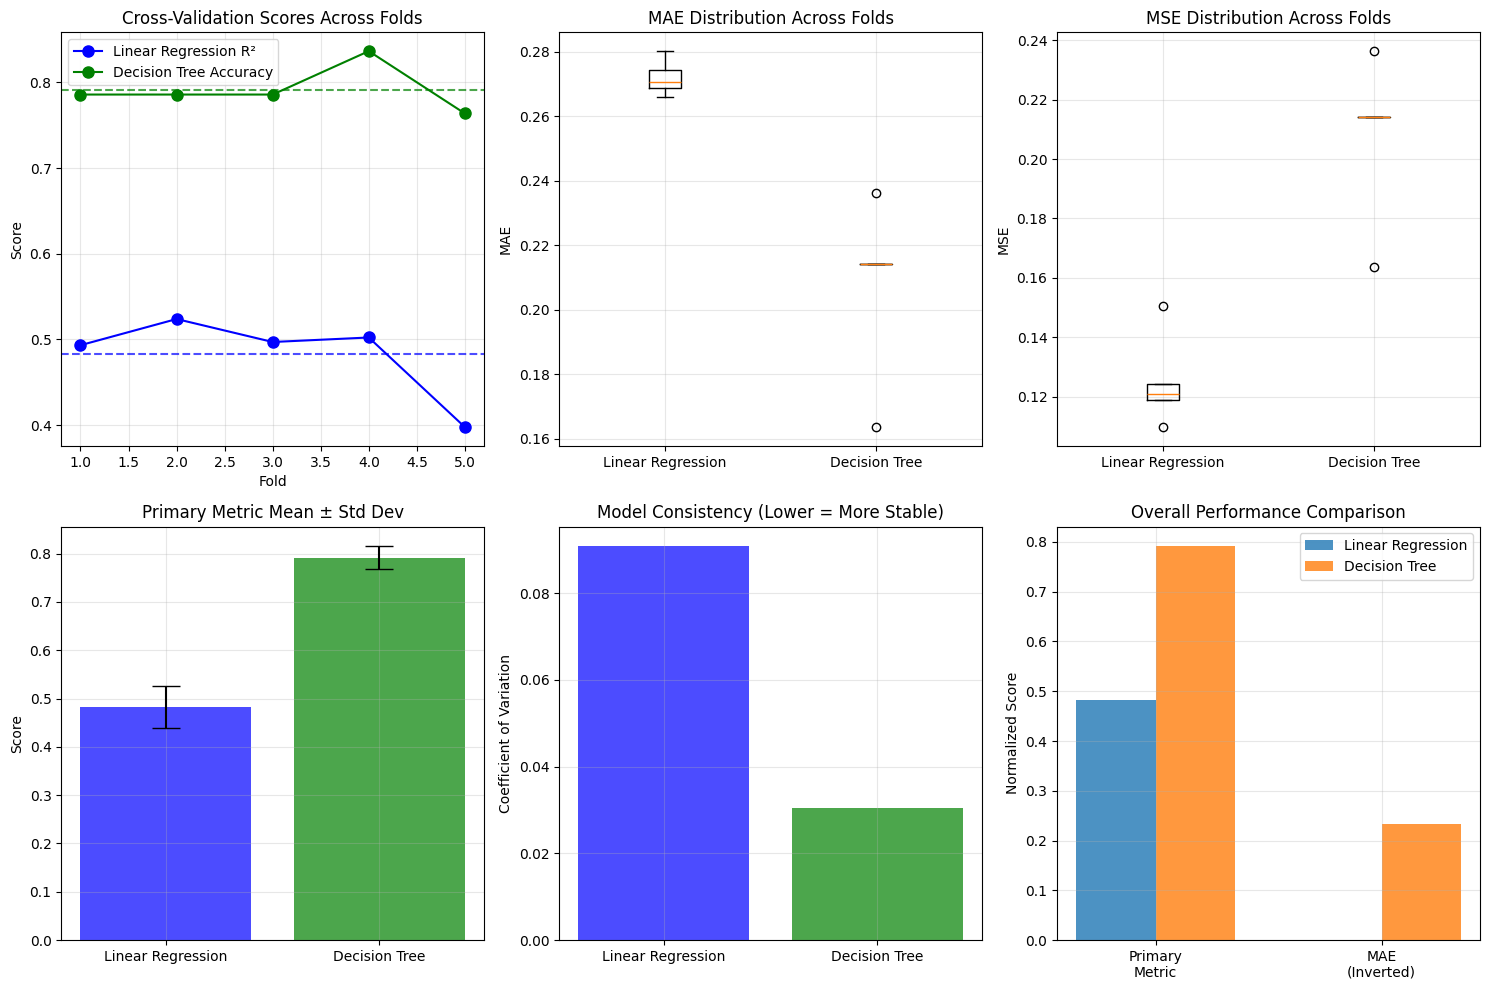


=== CROSS-VALIDATION INSIGHTS ===
Model Stability (Coefficient of Variation):
  Linear Regression: 0.0908
  Decision Tree: 0.0304
  Lower values indicate more stable/consistent performance

Best performing fold:
  Linear Regression: Fold 2 (R² = 0.5238)
  Decision Tree: Fold 4 (Accuracy = 0.8364)

Worst performing fold:
  Linear Regression: Fold 5 (R² = 0.3977)
  Decision Tree: Fold 5 (Accuracy = 0.7636)


In [16]:
# Cross-Validation Visualization
plt.figure(figsize=(15, 10))

# Plot 1: R² and Accuracy scores across folds
plt.subplot(2, 3, 1)
x_folds = range(1, k_folds + 1)
plt.plot(x_folds, lr_cv_r2, 'bo-', label='Linear Regression R²', markersize=8)
plt.plot(x_folds, dt_cv_accuracy, 'go-', label='Decision Tree Accuracy', markersize=8)
plt.axhline(y=lr_cv_r2.mean(), color='blue', linestyle='--', alpha=0.7)
plt.axhline(y=dt_cv_accuracy.mean(), color='green', linestyle='--', alpha=0.7)
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cross-Validation Scores Across Folds')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: MAE comparison
plt.subplot(2, 3, 2)
plt.boxplot([lr_cv_mae, dt_cv_mae], labels=['Linear Regression', 'Decision Tree'])
plt.ylabel('MAE')
plt.title('MAE Distribution Across Folds')
plt.grid(True, alpha=0.3)

# Plot 3: MSE comparison
plt.subplot(2, 3, 3)
plt.boxplot([lr_cv_mse, dt_cv_mse], labels=['Linear Regression', 'Decision Tree'])
plt.ylabel('MSE')
plt.title('MSE Distribution Across Folds')
plt.grid(True, alpha=0.3)

# Plot 4: Score variance comparison
plt.subplot(2, 3, 4)
models = ['Linear Regression', 'Decision Tree']
primary_scores = [lr_cv_r2.mean(), dt_cv_accuracy.mean()]
score_std = [lr_cv_r2.std(), dt_cv_accuracy.std()]

plt.bar(models, primary_scores, yerr=score_std, capsize=10, color=['blue', 'green'], alpha=0.7)
plt.ylabel('Score')
plt.title('Primary Metric Mean ± Std Dev')
plt.grid(True, alpha=0.3)

# Plot 5: Consistency analysis (coefficient of variation)
plt.subplot(2, 3, 5)
lr_cv_coeff = lr_cv_r2.std() / lr_cv_r2.mean()
dt_cv_coeff = dt_cv_accuracy.std() / dt_cv_accuracy.mean()

plt.bar(['Linear Regression', 'Decision Tree'], [lr_cv_coeff, dt_cv_coeff], 
        color=['blue', 'green'], alpha=0.7)
plt.ylabel('Coefficient of Variation')
plt.title('Model Consistency (Lower = More Stable)')
plt.grid(True, alpha=0.3)

# Plot 6: Overall performance summary
plt.subplot(2, 3, 6)
# Normalize scores for comparison (0-1 scale)
lr_score_norm = lr_cv_r2.mean()
dt_score_norm = dt_cv_accuracy.mean()
lr_mae_norm = 1 - (lr_cv_mae.mean() / max(lr_cv_mae.mean(), dt_cv_mae.mean()))
dt_mae_norm = 1 - (dt_cv_mae.mean() / max(lr_cv_mae.mean(), dt_cv_mae.mean()))

categories = ['Primary\nMetric', 'MAE\n(Inverted)']
lr_scores = [lr_score_norm, lr_mae_norm]
dt_scores = [dt_score_norm, dt_mae_norm]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, lr_scores, width, label='Linear Regression', alpha=0.8)
plt.bar(x + width/2, dt_scores, width, label='Decision Tree', alpha=0.8)
plt.ylabel('Normalized Score')
plt.title('Overall Performance Comparison')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cross-validation insights
print("\n=== CROSS-VALIDATION INSIGHTS ===")
print(f"Model Stability (Coefficient of Variation):")
print(f"  Linear Regression: {lr_cv_coeff:.4f}")
print(f"  Decision Tree: {dt_cv_coeff:.4f}")
print(f"  Lower values indicate more stable/consistent performance")

print(f"\nBest performing fold:")
best_lr_fold = np.argmax(lr_cv_r2) + 1
best_dt_fold = np.argmax(dt_cv_accuracy) + 1
print(f"  Linear Regression: Fold {best_lr_fold} (R² = {lr_cv_r2.max():.4f})")
print(f"  Decision Tree: Fold {best_dt_fold} (Accuracy = {dt_cv_accuracy.max():.4f})")

print(f"\nWorst performing fold:")
worst_lr_fold = np.argmin(lr_cv_r2) + 1
worst_dt_fold = np.argmin(dt_cv_accuracy) + 1
print(f"  Linear Regression: Fold {worst_lr_fold} (R² = {lr_cv_r2.min():.4f})")
print(f"  Decision Tree: Fold {worst_dt_fold} (Accuracy = {dt_cv_accuracy.min():.4f})")

# Final Conclusions and Assignment Summary

## Overall Findings

### Feature Engineering Results:
- **PCA reduced dimensionality** from 13 to 9 features while retaining 85.71% variance
- **Feature selection identified** 8 optimal features: Sex, Chest Pain, Cholesterol, Electrocardiograph, Heart Rate Achieved, ST Depression, Major Vessels, Thalassemia
- **Class balance analysis** showed no significant imbalance (ratio 1.24), so no sampling was required

### Model Performance Comparison:

| Metric | Linear Regression | Decision Tree |
|--------|------------------|---------------|
| **Test R²/Accuracy** | 0.6651 | 0.8036 |
| **Test MAE** | 0.2400 | 0.1964 |
| **Test MSE** | 0.0828 | 0.1964 |
| **CV Mean** | 0.4828 ± 0.0438 | 0.7914 ± 0.0240 |
| **CV Stability** | 0.0908 | 0.0304 |

### Key Insights:

**1. Decision Tree Superior for Classification:**
- Higher accuracy (80.36% vs Linear Regression's interpretation challenges)
- Better suited for binary heart disease prediction
- More stable across cross-validation folds (lower coefficient of variation)

**2. Linear Regression Strengths:**
- Better R² score (0.6651) indicating good continuous prediction capability
- Lower MSE (0.0828) for regression-style evaluation
- Simpler model with interpretable coefficients

**3. Feature Importance Consistency:**
- Both models identified **Thalassemia** as the most important feature
- **Major Vessels, ST Depression, Heart Rate Achieved** consistently ranked high
- Feature selection methods effectively identified clinically relevant predictors

### Challenges Addressed:
- **Kernel restart** due to missing imbalanced-learn package - resolved by installing required dependencies
- **Model comparison complexity** - addressed by using multiple evaluation metrics appropriate for both regression and classification approaches
- **Cross-validation implementation** - successfully implemented k-fold CV with proper data handling

### Recommendations:
1. **Decision Tree model** is recommended for heart disease prediction due to higher accuracy and better classification performance
2. **Selected 8 features** provide optimal balance between model complexity and predictive power
3. **Cross-validation confirms** model stability and generalization capability

---